# Power of Graph Products
In this notebook we will explore the power of graph products. We will use the following graph products:
* Cartesian product
* Strong product
* Tensor product

We will explore the use of different embeddings and the effect of different graph products on the embeddings.

In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
from sklearn.manifold import TSNE

from compare import compare_embeddings as compare
from counting import embed_graph_cycles as cycles
from weisfeiler_lehman import embed_graph_wl as wl
from product import get_all_products as products
from visual import plot_horizontally as plot

We will start by using all possible non-isomorphic graphs with a maximum of 7 nodes that are connected. This gives us a total of 995 graphs.

In [2]:
Gs = [G for G in nx.graph_atlas_g() if not nx.is_empty(G) and nx.is_connected(G)]
len(Gs)

995

## Preprocessing
We will start by assembeling all the graphs and graph products in a structured manner to make it easier to analyze different embedding methods. Furthermore we will create different categorical labels for the graphs. 

### Factor graphs
Using different factor graphs could change the embedding, and therefore the effect of the graph products. We will use the following factor graphs:
* Complete graph
* Path graph
* Star graph

Regarding the size of the factor graphs, we will use the following sizes:
* 3 nodes
* 5 nodes
* 7 nodes

In [3]:
factor_graphs = {
    'K3': nx.complete_graph(3),
    'K5': nx.complete_graph(5),
    'K7': nx.complete_graph(7),
    'P3': nx.path_graph(3),
    'P5': nx.path_graph(5),
    'P7': nx.path_graph(7),
    # star graph with 3 nodes is equivalent to path graph with 3 nodes
    'S5': nx.star_graph(5),
    'S7': nx.star_graph(7),
}

### Graph products
Now we will create the graph products of the factor graphs with all the graphs considered.

In [4]:
graph_products = pd.DataFrame(index=factor_graphs.keys(), columns=['Cartesian', 'Strong', 'Tensor'])
graph_products.index.name = 'Factor Graph'
graph_products.columns.name = 'Graph Product'

for factor in factor_graphs:
    FG = factor_graphs[factor]
    cartesian, strong, tensor = products(Gs, FG)
    
    graph_products.loc[factor, 'Cartesian'] = cartesian
    graph_products.loc[factor, 'Strong'] = strong
    graph_products.loc[factor, 'Tensor'] = tensor


### Categorical Labels
We will create categorical labels for the graphs. The labels will be based on:
* Number of nodes
* Number of edges
* Highest degree

In [32]:
num_nodes_per_graph = np.array([G.number_of_nodes() for G in Gs])
num_edges_per_graph = np.array([G.number_of_edges() for G in Gs])
highest_degree_per_graph = np.array([max(dict(G.degree()).values()) for G in Gs])

node_normalized_highest_degree = highest_degree_per_graph / num_nodes_per_graph
edge_normalized_highest_degree = highest_degree_per_graph / num_edges_per_graph

def get_color_encoding(categorization):
    available_categories = set(categorization)
    
    hue_values = np.linspace(0, 1, len(available_categories))
    colors = [hsv_to_rgb((hue, 1, 0.65)) for hue in hue_values]

    color_encoding = {}
    for category in available_categories:
        color_encoding[category] = colors.pop()
    return [color_encoding[category] for category in categorization]

## Cycle counting
We will use the cycle counting method by preparing embedding each graph using a vector, where each entry contains the number of cycles of a certain length (the length is the index of the entry). We will then use different graph products and observe, how the cycle counts change.

### Embeddings
For all these graph products, as well as the initial graphs, we will create embeddings by counting cycles of different lengths. We will use an embedding size of 7*7=49, which is the maximum length of cycles in a graph product of two graphs with each 7 nodes.

In [5]:
cycle_embedded_graphs = cycles(Gs, 49)
cycle_embedded_products = graph_products.map(lambda x: cycles(x, 49))

### Evaluation and Comparison
In this section, we will evaluate, how many graphs, that are isomorphic to each other, are mapped to the same embedding. We will also compare the embeddings of the different graph products.

In [6]:
cycle_results = compare(cycle_embedded_graphs, index=True)
cycle_product_results = cycle_embedded_products.map(lambda x: compare(x, index=True))

In [7]:
print("Number of non-isomorphic graphs with the same embedding: {}".format(cycle_results[0]))

Number of non-isomorphic graphs with the same embedding: 14239


In [8]:
cycle_product_results.map(lambda x: x[0])

Graph Product,Cartesian,Strong,Tensor
Factor Graph,,,
K3,1096,11795,255
K5,1040,9086,108
K7,1039,9086,96
P3,1407,787,7311
P5,1404,33,549
P7,1404,11,121
S5,185,2570,7224
S7,185,1390,7224


Next we will analyze if there are any pairs of graphs, that have the same embedding after a graph product, but not before. This would mean, that the graph product has worsened the embedding for this specific case.

In [9]:
cycle_product_results.map(lambda x: len(x[1] - cycle_results[1]))

Graph Product,Cartesian,Strong,Tensor
Factor Graph,,,
K3,48,5210,29
K5,10,2520,9
K7,11,2520,6
P3,257,158,4648
P5,255,3,201
P7,255,0,22
S5,32,1386,4573
S7,32,379,4573


### Visualization
Seeing the effectiveness of the graph products, we will further investigate the embeddings of them by visualizing them. We will use the following visualization methods:
* Examples of graphs with the same embedding (before and after graph products)
* Examples of graphs with the same embedding (only after graph products)
* Examples of graphs with different embeddings (only after graph products)
* t-SNE

In [10]:
original_idx = cycle_results[1]
comparative_idx = cycle_product_results.loc['K7', 'Tensor'][1]

def plot_dual_examples(set_idx_pairs, num_examples=3):
    idx_pairs = list(set_idx_pairs)
    for i in range(num_examples):
        graph_pair = [Gs[idx_pairs[i][0]], Gs[idx_pairs[i][1]]]
        plot(graph_pair, titles=['Graph 1', 'Graph 2'], figsize=(10, 5))

#### Examples of graphs with the same embedding (before and after graph products)

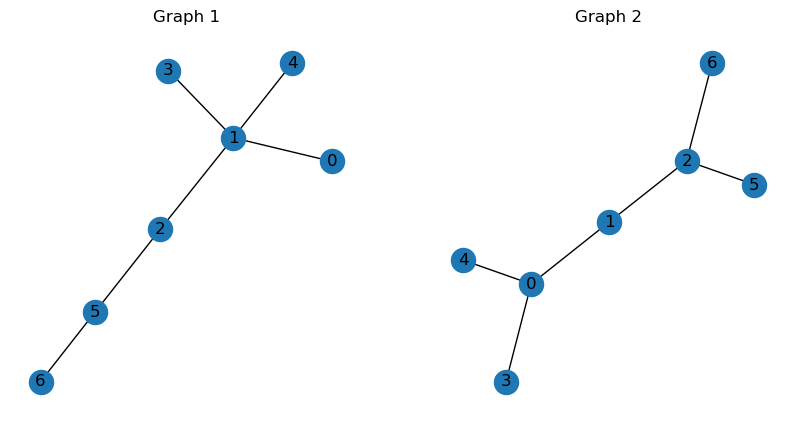

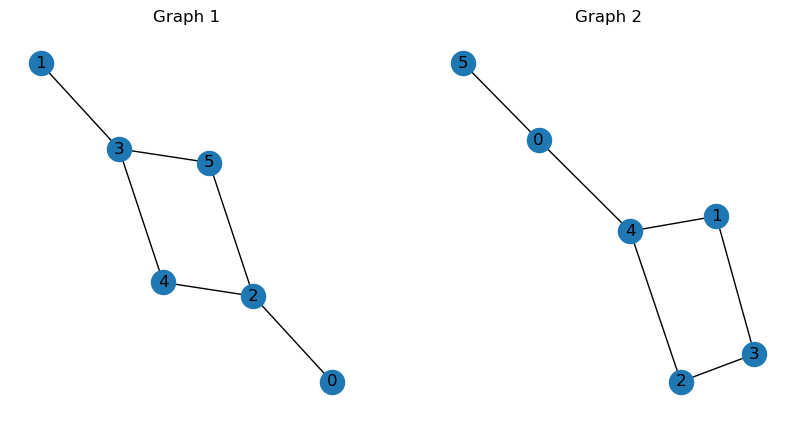

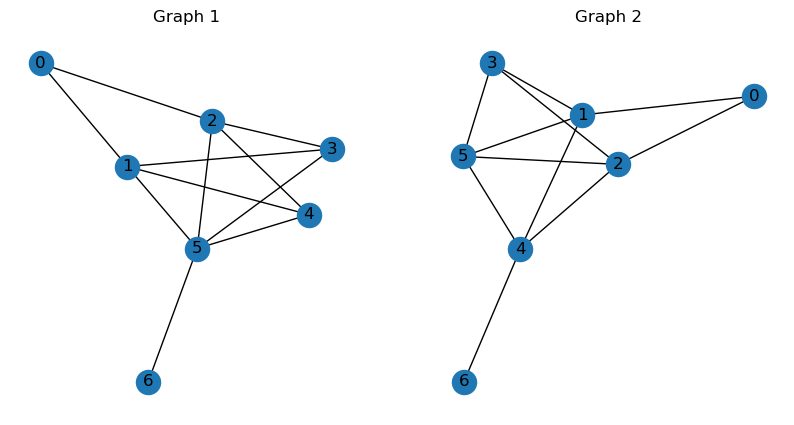

In [11]:
common_idx = original_idx.intersection(comparative_idx)

plot_dual_examples(common_idx)

#### Examples of graphs with the same embedding (only after graph products)

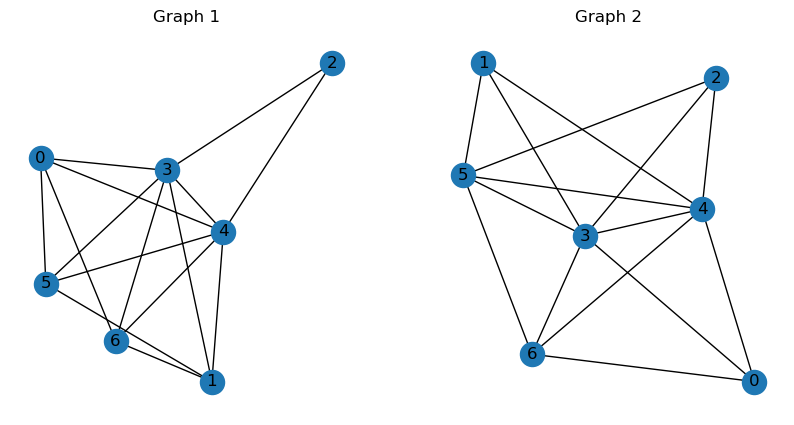

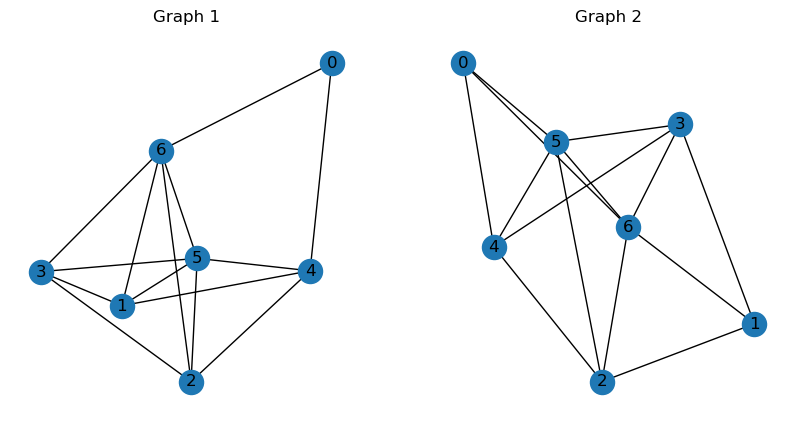

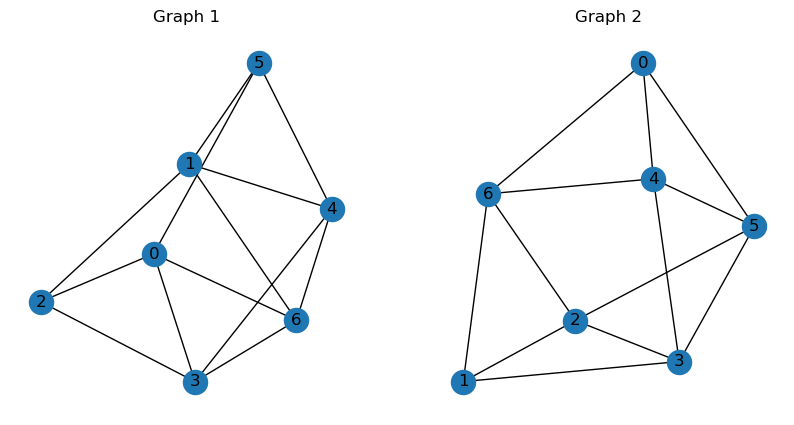

In [12]:
same_only_after_idx = comparative_idx - original_idx

plot_dual_examples(same_only_after_idx)

#### Examples of graphs with different embeddings (only after graph products)

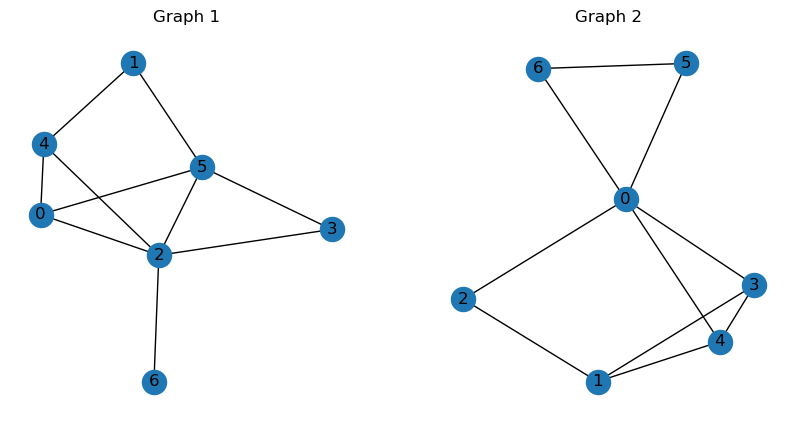

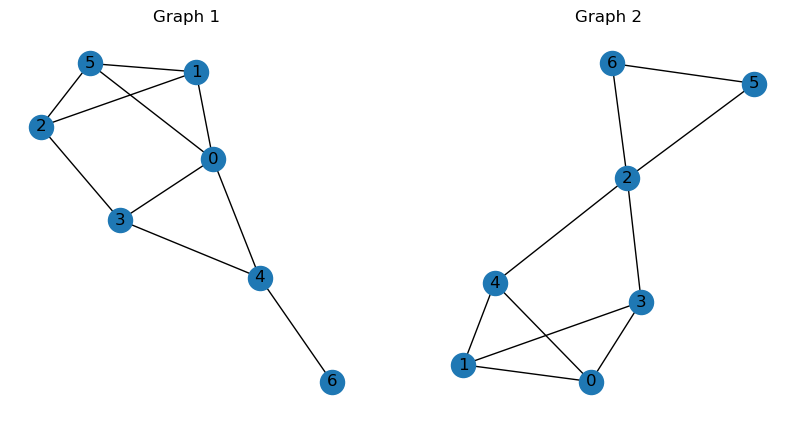

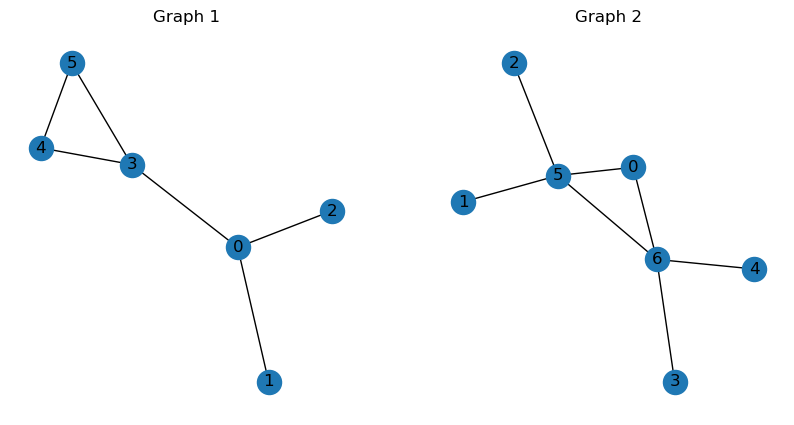

In [13]:
different_only_after_idx = original_idx - comparative_idx

plot_dual_examples(different_only_after_idx)

#### t-SNE

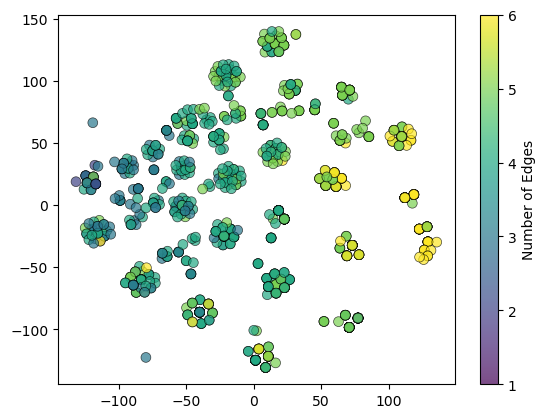

In [53]:
tsne = TSNE(n_components=2)
tsne_graphs = tsne.fit_transform(cycle_embedded_graphs)

sc = plt.scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=highest_degree_per_graph,
                 cmap='viridis',
                 s=50,
                 edgecolors="black",
                 linewidths=0.5)
plt.colorbar(sc, label='Number of Edges')
plt.show()

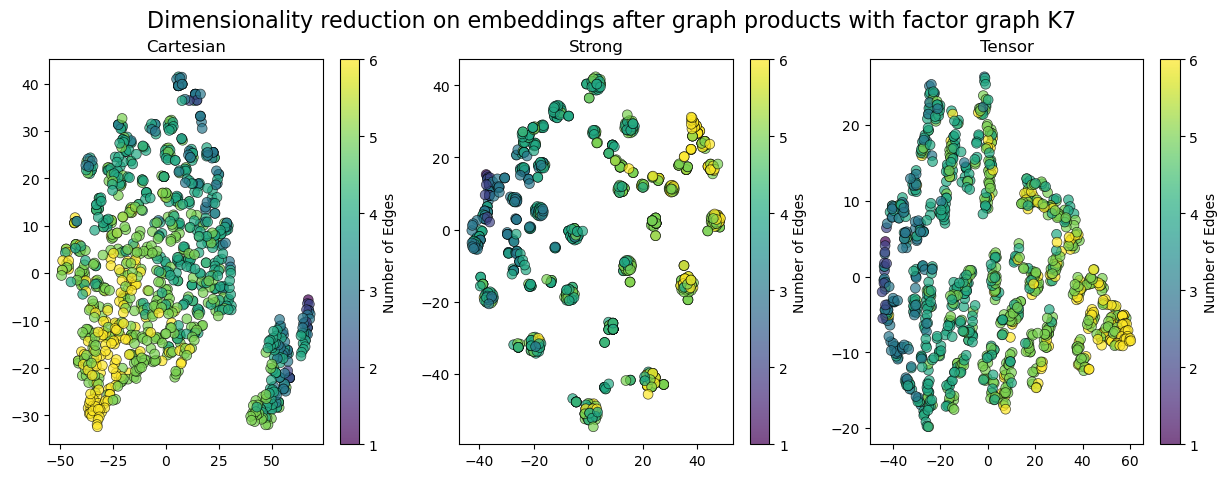

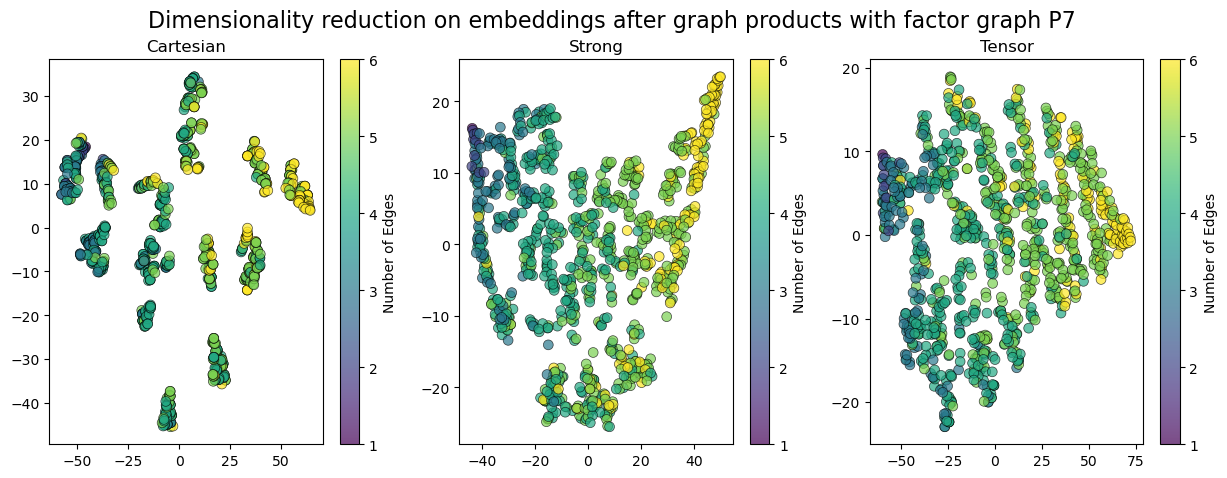

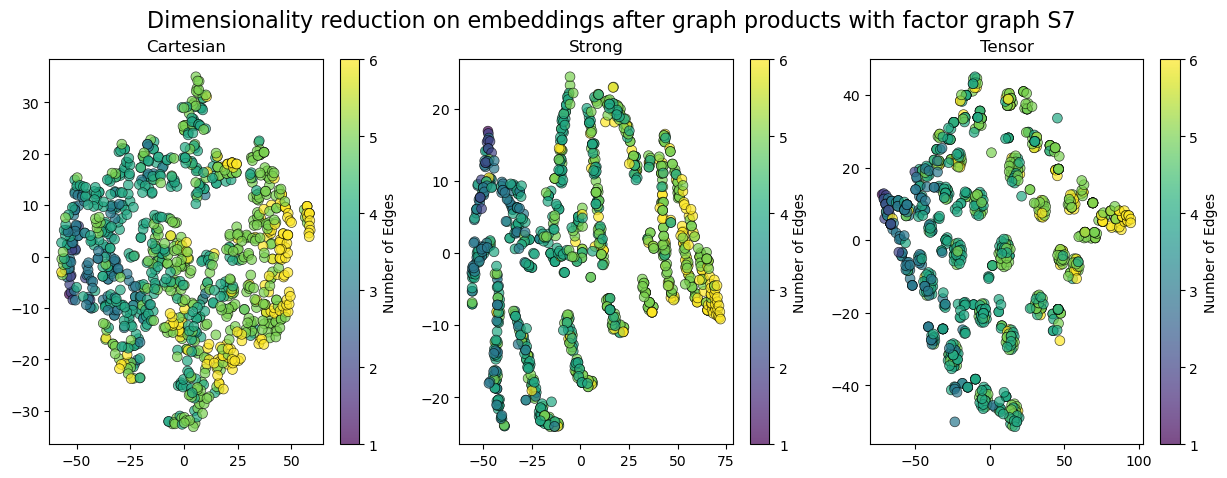

In [54]:
for factor_graph in ['K7', 'P7', 'S7']:
    comparative_cycle_embedded_graphs = cycle_embedded_products.loc[factor_graph]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, (product_name, embeddings) in enumerate(comparative_cycle_embedded_graphs.items()):
        tsne = TSNE(n_components=2)
        tsne_graphs = tsne.fit_transform(embeddings)
        sc = axes[i].scatter(tsne_graphs[:, 0],
                 tsne_graphs[:, 1],
                 alpha=0.7,
                 c=highest_degree_per_graph,
                 cmap='viridis',
                 s=50,
                 edgecolors="black",
                 linewidths=0.5)
        plt.colorbar(sc, label='Number of Edges')
        axes[i].set_title(product_name)
    fig.suptitle("Dimensionality reduction on embeddings after graph products with factor graph {}".format(factor_graph), fontsize=16)
    plt.show()

## Weisfeiler-Lehman
Next will use the standard one dimensional Weisfeiler-Lehman isomorphisim test and perform the same evaluation and comparison as before.

### Embeddings
We will use 10 iterations of the Weisfeiler-Lehman algorithm to create the embeddings.

In [16]:
wl_embedded_graphs = wl(Gs, 10)
wl_embedded_products = graph_products.map(lambda x: wl(x, 10))

### Evaluation and Comparison
In this section, we will evaluate the effectiveness of graph products ability to enhance the WL isomorphism test. 

In [17]:
wl_results = compare(wl_embedded_graphs)
wl_product_results = wl_embedded_products.map(lambda x: compare(x))

In [18]:
wl_results

20

In [19]:
wl_product_results

Graph Product,Cartesian,Strong,Tensor
Factor Graph,,,
K3,20,20,20
K5,20,20,20
K7,20,20,20
P3,20,20,20
P5,20,20,20
P7,20,20,20
S5,20,20,20
S7,20,20,20


### Conclusion and Discussion
As we can see from the table above, the graph products showed no effect on enhancing the WL isomorphism test.